In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [10]:
data = pd.read_excel("processed_data.xlsx")

# Преобразуем колонку 'dt' в DatetimeIndex
data['dt'] = pd.to_datetime(data['dt'])
data = data.set_index('dt')  # Устанавливаем 'dt' как индекс

# Удаляем колонку 'dt', если она не нужна (так как есть год, месяц, квартал)
data = data.drop('dt', axis=1, errors='ignore')

targeted = data['Price'].dropna()

In [11]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['quarter'] = data.index.quarter

for lag in [1, 2, 3, 6, 12]:
    data[f'lag_{lag}'] = data['Price'].shift(lag)
    
# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']
target = 'Price'

In [12]:
train_size = int(len(data) * 0.8)  # 80% тренировочных данных
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train = train_data.drop('Price', axis=1)
y_train = train_data['Price']
X_test = test_data.drop('Price', axis=1)
y_test = test_data['Price']

In [13]:
# Создание модели
model = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=1,
    reg_alpha=0.5,
    reg_lambda=1.0
)

# Обучение
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)

# Метрики для кросс-валидации
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Кросс-валидация (например, 5 фолдов)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Предсказание и оценка
y_pred = model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² на каждом фолде: {scores}")
print(f"Средний R²: {scores.mean():.4f}")

[0]	validation_0-rmse:28750.65043
[1]	validation_0-rmse:28561.55268
[2]	validation_0-rmse:28464.14775
[3]	validation_0-rmse:28283.83684
[4]	validation_0-rmse:28194.63621
[5]	validation_0-rmse:28043.54598
[6]	validation_0-rmse:27865.14499
[7]	validation_0-rmse:27783.80038
[8]	validation_0-rmse:27715.59322
[9]	validation_0-rmse:27537.07282
[10]	validation_0-rmse:27405.53954
[11]	validation_0-rmse:27341.21285
[12]	validation_0-rmse:26912.83791
[13]	validation_0-rmse:26745.56332
[14]	validation_0-rmse:26684.30520
[15]	validation_0-rmse:26276.24762
[16]	validation_0-rmse:26205.58931
[17]	validation_0-rmse:25812.39023
[18]	validation_0-rmse:25621.04167
[19]	validation_0-rmse:25566.27755
[20]	validation_0-rmse:25074.59191
[21]	validation_0-rmse:24995.03159
[22]	validation_0-rmse:24547.66888
[23]	validation_0-rmse:24498.22798
[24]	validation_0-rmse:24322.59163
[25]	validation_0-rmse:23866.13442
[26]	validation_0-rmse:23750.82432
[27]	validation_0-rmse:23705.33562
[28]	validation_0-rmse:23292.4

[31]	validation_0-rmse:22501.42114
[32]	validation_0-rmse:22412.11159
[33]	validation_0-rmse:22371.22306
[34]	validation_0-rmse:21971.17150
[35]	validation_0-rmse:21811.17187
[36]	validation_0-rmse:21756.11466
[37]	validation_0-rmse:21394.62916
[38]	validation_0-rmse:21356.47920
[39]	validation_0-rmse:20985.66525
[40]	validation_0-rmse:20880.91974
[41]	validation_0-rmse:20843.82813
[42]	validation_0-rmse:20507.19844
[43]	validation_0-rmse:20365.20090
[44]	validation_0-rmse:20331.93008
[45]	validation_0-rmse:19990.79383
[46]	validation_0-rmse:19931.18973
[47]	validation_0-rmse:19678.34118
[48]	validation_0-rmse:19646.97649
[49]	validation_0-rmse:19326.40591
[50]	validation_0-rmse:19225.62064
[51]	validation_0-rmse:19184.45140
[52]	validation_0-rmse:18892.64227
[53]	validation_0-rmse:18863.47331
[54]	validation_0-rmse:18565.92075
[55]	validation_0-rmse:18498.47460
[56]	validation_0-rmse:18258.97960
[57]	validation_0-rmse:18231.40677
[58]	validation_0-rmse:18117.40397
[59]	validation_0-rm

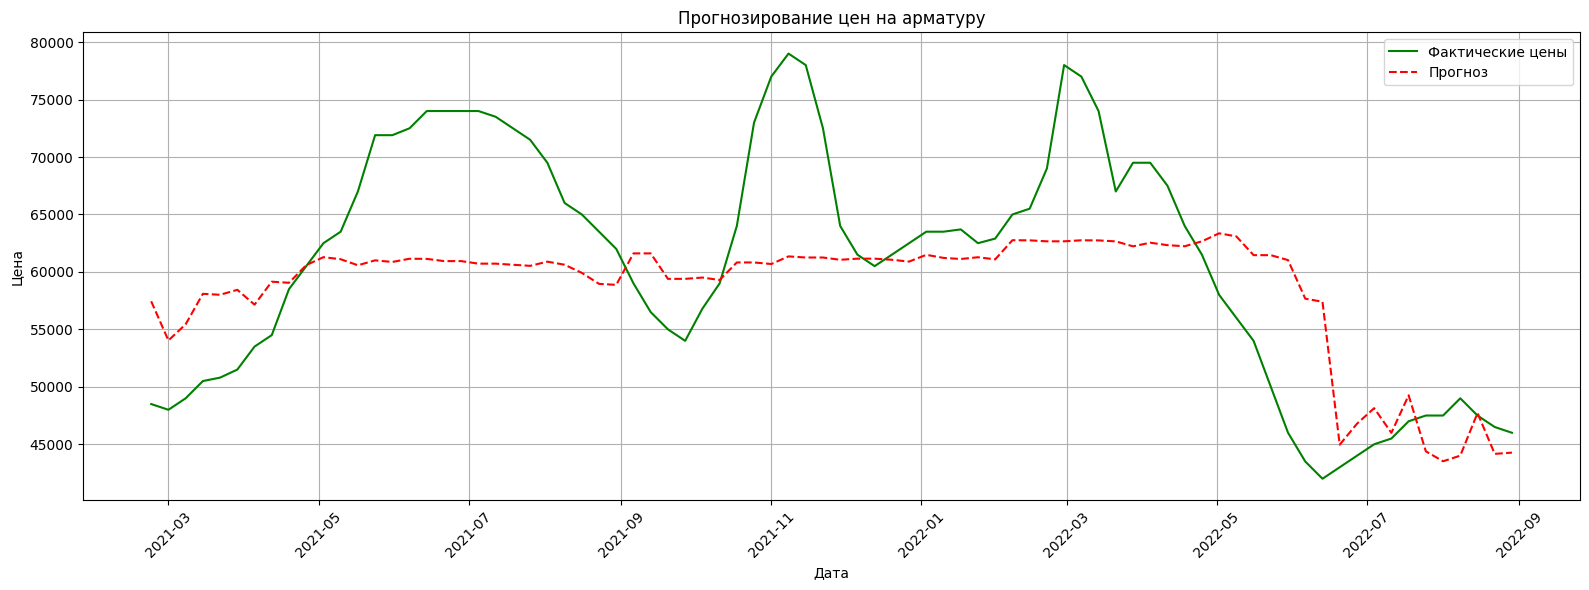

In [14]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

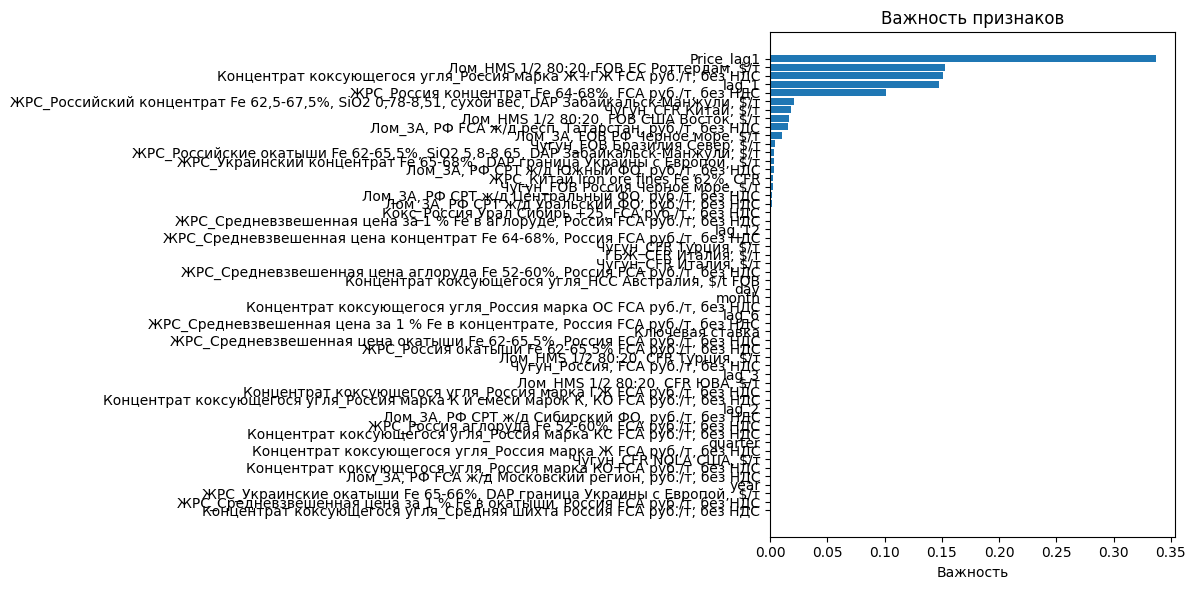

In [15]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

features = X_train.columns  # Если X_train — это DataFrame

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

In [16]:
# Сохранение в JSON-формате
model.save_model("xgboost_model.json")